# Prepare data

In [113]:
from google.colab import files


uploaded = files.upload()

# data link: https://finance.yahoo.com/quote/MSFT/history/
# reference notebook: https://colab.research.google.com/drive/1CBIdPxHn_W2ARx4VozRLIptBrXk7ZBoM?usp=sharing

Saving AAPL.csv to AAPL (1).csv


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AAPL.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-28,38.947498,39.082500,38.415001,39.075001,37.504608,104768400
1,2019-01-29,39.062500,39.532501,38.527500,38.669998,37.115887,166348800
2,2019-01-30,40.812500,41.537498,40.057499,41.312500,39.652184,244439200
3,2019-01-31,41.527500,42.250000,41.139999,41.610001,39.937729,162958400
4,2019-02-01,41.740002,42.244999,41.482498,41.630001,39.956928,130672400
...,...,...,...,...,...,...,...
1254,2024-01-22,192.300003,195.330002,192.259995,193.889999,193.889999,60133900
1255,2024-01-23,195.020004,195.750000,193.830002,195.179993,195.179993,42355600
1256,2024-01-24,195.419998,196.380005,194.339996,194.500000,194.500000,53631300
1257,2024-01-25,195.220001,196.270004,193.110001,194.169998,194.169998,54822100


In [115]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2019-01-28,39.075001
1,2019-01-29,38.669998
2,2019-01-30,41.312500
3,2019-01-31,41.610001
4,2019-02-01,41.630001
...,...,...
1254,2024-01-22,193.889999
1255,2024-01-23,195.179993
1256,2024-01-24,194.500000
1257,2024-01-25,194.169998


In [116]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-117-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


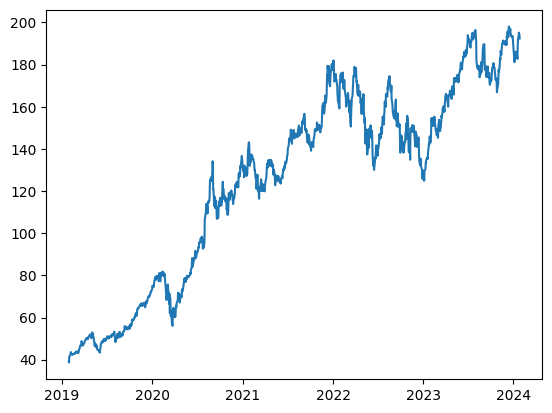

In [117]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

## Create data frame (multi window) for LSTM

In [379]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 10
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2019-02-11,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998,39.075001
2019-02-12,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998
2019-02-13,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500
2019-02-14,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001
2019-02-15,42.605000,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993
2024-01-23,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998
2024-01-24,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999


In [380]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np, shifted_df_as_np.shape

(array([[ 42.357498,  42.602501,  42.735001, ...,  41.3125  ,  38.669998,
          39.075001],
        [ 42.7225  ,  42.357498,  42.602501, ...,  41.610001,  41.3125  ,
          38.669998],
        [ 42.544998,  42.7225  ,  42.357498, ...,  41.630001,  41.610001,
          41.3125  ],
        ...,
        [194.5     , 195.179993, 193.889999, ..., 185.589996, 186.190002,
         185.139999],
        [194.169998, 194.5     , 195.179993, ..., 185.919998, 185.589996,
         186.190002],
        [192.419998, 194.169998, 194.5     , ..., 183.630005, 185.919998,
         185.589996]]),
 (1249, 11))

## Pre-processing

In [381]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-1.        , -0.99685394, -0.99515253, ..., -1.        ,
        -1.        , -0.99491968],
       [-0.99531305, -1.        , -0.99685394, ..., -0.99620528,
        -0.96685271, -1.        ],
       [-0.99759233, -0.99531305, -1.        , ..., -0.99595018,
        -0.96312089, -0.96685271],
       ...,
       [ 0.95364439,  0.9623761 ,  0.94581144, ...,  0.84030351,
         0.85047668,  0.83730555],
       [ 0.94940687,  0.95364439,  0.9623761 , ...,  0.84451279,
         0.84295027,  0.85047668],
       [ 0.92693533,  0.94940687,  0.95364439, ...,  0.81530323,
         0.84708978,  0.84295027]])

In [382]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1249, 10), (1249,))

## Flip data
Our data is from t-> t-10, but LSTM need input as t-10 -> t

In [383]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99491968, -1.        , -1.        , ..., -0.9845588 ,
        -0.99515253, -0.99685394],
       [-1.        , -0.96685271, -0.99620528, ..., -0.99515253,
        -0.99685394, -1.        ],
       [-0.96685271, -0.96312089, -0.99595018, ..., -0.99685394,
        -1.        , -0.99531305],
       ...,
       [ 0.83730555,  0.85047668,  0.84030351, ...,  0.91589216,
         0.94581144,  0.9623761 ],
       [ 0.85047668,  0.84295027,  0.84451279, ...,  0.94581144,
         0.9623761 ,  0.95364439],
       [ 0.84295027,  0.84708978,  0.81530323, ...,  0.9623761 ,
         0.95364439,  0.94940687]])

## Split train, test set

In [384]:
split_index = int(len(X) * 0.95)

split_index

1186

In [385]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 10), (63, 10), (1186,), (63,))

In [386]:
# typical input shape for an LSTM in PyTorch is (batch_size, sequence_length, input_size)
# if you only consider the closing price at each time step, input_size would be 1

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1186, 10, 1), (63, 10, 1), (1186, 1), (63, 1))

In [387]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape
# (window sample, time steps, features)

(torch.Size([1186, 10, 1]),
 torch.Size([63, 10, 1]),
 torch.Size([1186, 1]),
 torch.Size([63, 1]))

## Create data loader for PyTorch

In [388]:
# generally when training models in Pytorch, we use Dataset instead of raw tensor, the use Dataloader to get our batches of data
# In PyTorch, DataLoader is a built-in class that provides an efficient and flexible way to load data into a model for training or inference.
# It is particularly useful for handling large datasets that cannot fit into memory, as well as for performing data augmentation and preprocessing.


from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# LSTM model


In [389]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Noted: x is a tensor, shape as (batch_size,lookback,1)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0,c0))  # we only retrieve output (shape: (hidden_size))
        out = self.fc(out[:, -1, :])   # select last timestep hidden state to perform fully connected (convert num of bath_size output to 1 output)
        return out

model = LSTM(1, 10, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

## Training model

In [390]:
training_loss = []
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):

        # x_batch: torch.Size([16, 10, 1]), 16 training example, each with 10 sequence data
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)   # tensor with 16 (batch_size) value, AddmmBackward0 function
        loss = loss_function(output, y_batch) # tensor with 1 value, MseLossBackward0 function

        running_loss += loss.item()  # accumulative the loss value

        optimizer.zero_grad()  # zero out the saved deri
        loss.backward()  # calculate deriative of loss function w.r.t each param, and saved to param.grad properties
        optimizer.step()  # update the weights base on the deriative

    avg_loss_across_batches = running_loss / len(train_loader)
    training_loss.append(avg_loss_across_batches)

    print(running_loss)

In [391]:
validating_loss = []
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    validating_loss.append(avg_loss_across_batches)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [392]:
learning_rate = 0.001
num_epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
23.569883465766907
Val Loss: 0.586
***************************************************

Epoch: 2
10.166946843266487
Val Loss: 0.208
***************************************************

Epoch: 3
1.5496353851631284
Val Loss: 0.099
***************************************************

Epoch: 4
0.9396311142481863
Val Loss: 0.054
***************************************************

Epoch: 5
0.6784834165591747
Val Loss: 0.038
***************************************************

Epoch: 6
0.5096234208904207
Val Loss: 0.025
***************************************************

Epoch: 7
0.4033128449227661
Val Loss: 0.022
***************************************************

Epoch: 8
0.33057526440825313
Val Loss: 0.016
***************************************************

Epoch: 9
0.2765741207404062
Val Loss: 0.011
***************************************************

Epoch: 10
0.24082337715663016
Val Loss: 0.010
***************************************************

Epoch: 11
0.209155520889908

# Plot for y_train

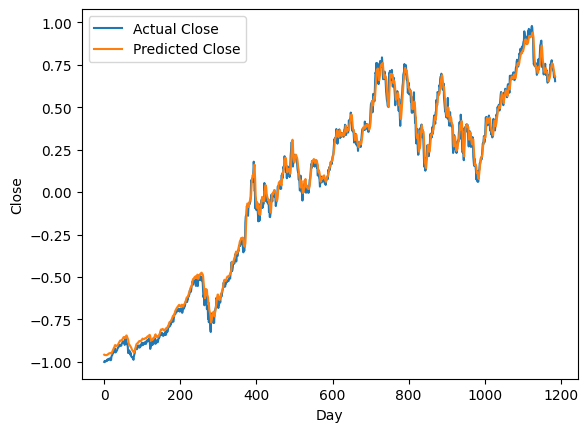

In [393]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Plot for rescaled y_train
We need to see the actual price

In [394]:
# Reverse scale for prediction

train_predictions = predicted.flatten()  # make sure train_predictions have only 1 dimension: (9032, 1) -> (9032)

dummies = np.zeros((X_train.shape[0], lookback+1))  # making a matrix with same shape as "shifted_df" (9032, 11)
dummies[:, 0] = train_predictions # assign the Close column to train_predictions
dummies = scaler.inverse_transform(dummies) # still (9032, 11), but scaler used to work with (9508, 11), why it's still work?

train_predictions = dc(dummies[:, 0])
train_predictions.shape

(1186,)

In [395]:
# Reverse scale for y_train

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 42.357498  ,  42.72250022,  42.54499832, ..., 172.99999803,
       173.44000224, 171.10000814])

# Plot for new y_train (reverse scale)

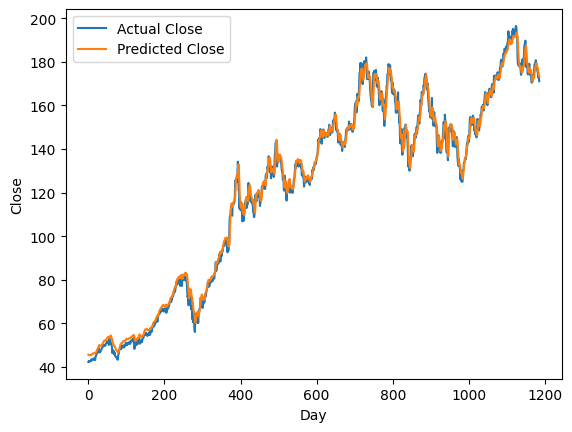

In [396]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


#Evaluate Model

In [397]:
from sklearn.metrics import mean_squared_error

##Training Loss

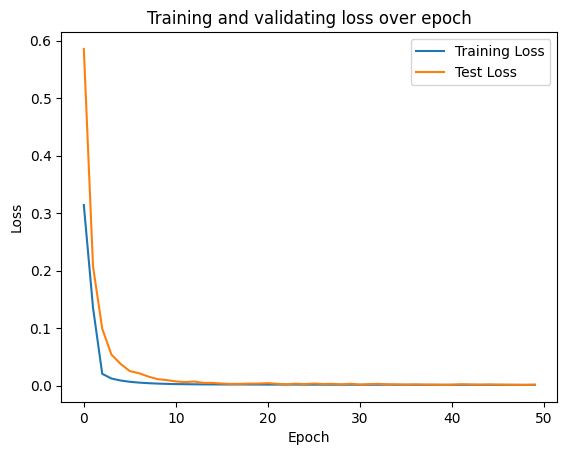

In [398]:
plt.title("Training and validating loss over epoch")
plt.plot(training_loss, label='Training Loss')
plt.plot(validating_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


##Evaluate on Test Set

In [399]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions.shape

(63,)

In [400]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

### Plot for y_test

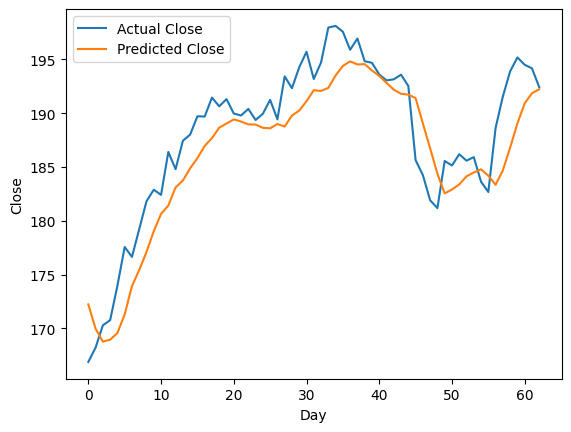

34345.26575115162


In [401]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
error =  mean_squared_error(test_predictions, y_test)
print(error)

In [402]:

error =  mean_squared_error(test_predictions, y_test)
print(error)

34345.26575115162


# RNN
Implement a simple RNN to compare with LSTM

In [403]:
# # Importing necessary libraries
# import torch.nn.functional as F

# # Define a simple RNN model
# class SimpleRNN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_stacked_layers):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_stacked_layers = num_stacked_layers

#         self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         batch_size = x.size(0)
#         h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

#         out, _ = self.rnn(x, h0)
#         out = self.fc(out[:, -1, :])
#         return out

# # Instantiate the SimpleRNN model
# model_rnn = SimpleRNN(1, 4, 1)
# model_rnn.to(device)

# # Define the optimizer and loss function for RNN
# optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)
# loss_function_rnn = nn.MSELoss()

# # Training loop for RNN
# for epoch in range(num_epochs):
#     train_one_epoch()
#     validate_one_epoch()

# # Make predictions using RNN
# with torch.no_grad():
#     predicted_rnn = model_rnn(X_train.to(device)).to('cpu').numpy()


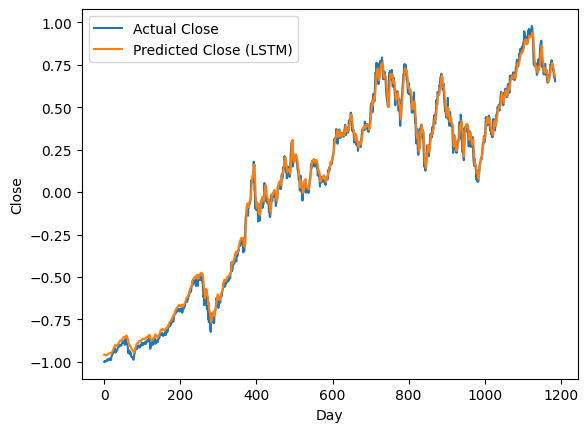

In [404]:
# Plot the predictions of both LSTM and RNN
plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close (LSTM)')
#plt.plot(predicted_rnn, label='Predicted Close (RNN)')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

# Predict future price

In [405]:
shifted_df # pandas sheet

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2019-02-11,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998,39.075001
2019-02-12,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998
2019-02-13,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500
2019-02-14,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001
2019-02-15,42.605000,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993
2024-01-23,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998
2024-01-24,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999


In [406]:
shifted_df.tail(1)
shifted_df_as_np[-1]

array([0.92693533, 0.94940687, 0.95364439, 0.9623761 , 0.94581144,
       0.91589216, 0.87883441, 0.8028114 , 0.81530323, 0.84708978,
       0.84295027])

In [407]:
shifted_df.tail(1)

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2024-01-26,192.419998,194.169998,194.5,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996


In [408]:
shifted_df_as_np

array([[-1.        , -0.99685394, -0.99515253, ..., -1.        ,
        -1.        , -0.99491968],
       [-0.99531305, -1.        , -0.99685394, ..., -0.99620528,
        -0.96685271, -1.        ],
       [-0.99759233, -0.99531305, -1.        , ..., -0.99595018,
        -0.96312089, -0.96685271],
       ...,
       [ 0.95364439,  0.9623761 ,  0.94581144, ...,  0.84030351,
         0.85047668,  0.83730555],
       [ 0.94940687,  0.95364439,  0.9623761 , ...,  0.84451279,
         0.84295027,  0.85047668],
       [ 0.92693533,  0.94940687,  0.95364439, ...,  0.81530323,
         0.84708978,  0.84295027]])

In [409]:
X # Close t-10 -> Close

array([[-0.99491968, -1.        , -1.        , ..., -0.9845588 ,
        -0.99515253, -0.99685394],
       [-1.        , -0.96685271, -0.99620528, ..., -0.99515253,
        -0.99685394, -1.        ],
       [-0.96685271, -0.96312089, -0.99595018, ..., -0.99685394,
        -1.        , -0.99531305],
       ...,
       [ 0.83730555,  0.85047668,  0.84030351, ...,  0.91589216,
         0.94581144,  0.9623761 ],
       [ 0.85047668,  0.84295027,  0.84451279, ...,  0.94581144,
         0.9623761 ,  0.95364439],
       [ 0.84295027,  0.84708978,  0.81530323, ...,  0.9623761 ,
         0.95364439,  0.94940687]])

In [410]:
X = dc(np.flip(shifted_df_as_np, axis=1))
X

array([[-0.99491968, -1.        , -1.        , ..., -0.99515253,
        -0.99685394, -1.        ],
       [-1.        , -0.96685271, -0.99620528, ..., -0.99685394,
        -1.        , -0.99531305],
       [-0.96685271, -0.96312089, -0.99595018, ..., -1.        ,
        -0.99531305, -0.99759233],
       ...,
       [ 0.83730555,  0.85047668,  0.84030351, ...,  0.94581144,
         0.9623761 ,  0.95364439],
       [ 0.85047668,  0.84295027,  0.84451279, ...,  0.9623761 ,
         0.95364439,  0.94940687],
       [ 0.84295027,  0.84708978,  0.81530323, ...,  0.95364439,
         0.94940687,  0.92693533]])

In [411]:
latest_10_day_as_np = X[-1, 1:] # on latest day, Close-9 -> Close column
latest_10_day_as_np # (10)
latest_10_day_as_tensor = torch.tensor(latest_10_day_as_np).float().to(device)
latest_10_day_as_tensor = latest_10_day_as_tensor.reshape(1,-1,1) # (1,10,1)
days_to_predict = 30

window_accumulated = np.empty((0, 11, 1)) # a 2D matrix contains multiple 11 days sequence (unscaled), we will use this array to rescale

for i in range(days_to_predict):
    next_day_price_as_tensor = model(latest_10_day_as_tensor) # (1,1)
    current_window = torch.cat([latest_10_day_as_tensor, next_day_price_as_tensor.unsqueeze(2)], dim=1) # (1,11,1), a window from Close-10 to Close (with Close as new predicted price)

    current_window_as_np = current_window.detach().numpy()
    window_accumulated= np.append(window_accumulated, current_window_as_np, axis=0)

    # reset latest_10_day_as_tensor to current window
    latest_10_day_as_tensor = current_window[:, 1:, :]

window_accumulated.shape

(30, 11, 1)

In [412]:
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),Close(t-10)
Date,,,,,,,,,,,
2019-02-11,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998,39.075001
2019-02-12,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500,38.669998
2019-02-13,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001,41.312500
2019-02-14,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001,41.610001
2019-02-15,42.605000,42.700001,42.544998,42.722500,42.357498,42.602501,42.735001,43.560001,43.544998,42.812500,41.630001
...,...,...,...,...,...,...,...,...,...,...,...
2024-01-22,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998,181.179993
2024-01-23,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999,185.559998
2024-01-24,194.500000,195.179993,193.889999,191.559998,188.630005,182.679993,183.630005,185.919998,185.589996,186.190002,185.139999


In [413]:
window_accumulated = scaler.inverse_transform(window_accumulated.squeeze()) # inverse_transform work with (x,11)
df = pd.DataFrame(window_accumulated.reshape(30, -1), columns=[f'Close-{10-i}' for i in range(11)])
df

,Close-10,Close-9,Close-8,Close-7,Close-6,Close-5,Close-4,Close-3,Close-2,Close-1,Close-0
0,186.201925,183.726507,182.753691,188.674080,191.560000,193.890000,195.166308,194.482675,194.143562,192.285284,191.688725
1,183.726507,182.753691,188.674080,191.560000,193.890000,195.179994,194.483138,194.151088,192.381821,191.688725,191.117040
2,182.753691,188.674080,191.560000,193.890000,195.179994,194.500000,194.151594,192.392689,191.795149,191.117040,190.500277
3,188.674080,191.560000,193.890000,195.179994,194.500000,194.169997,192.393420,191.807130,191.232939,190.500277,189.879317
4,191.560000,193.890000,195.179994,194.500000,194.169997,192.419997,191.807936,191.245987,190.626398,189.879317,189.282582
5,193.890000,195.179994,194.500000,194.169997,192.419997,191.837235,191.246865,190.640597,190.015730,189.282582,188.710912
6,195.179994,194.500000,194.169997,192.419997,191.837235,191.278772,190.641551,190.031088,189.428885,188.710912,188.167210
7,194.500000,194.169997,192.419997,191.837235,191.278772,190.676273,190.032120,189.445356,188.866689,188.167210,187.650812
8,194.169997,192.419997,191.837235,191.278772,190.676273,190.069675,189.446463,188.884227,188.331998,187.650812,187.156969
9,192.419997,191.837235,191.278772,190.676273,190.069675,189.486741,188.885406,188.350551,187.824158,187.156969,186.684747
